# Graph Machine Learning Problems

- Structral can only help if the labels/values of linked nodes are correlated.       
(Can be either positively correlated or negatively correlated)  
- Social network show assortative mixing, bias in favor of connections between network nodes with similary properties.         
    - homophily (同质): similar characteristic -> connection
    - influence（影响）: connection -> similary characteristic

- Can work with constructed(induced) similarity network.

## 1. Network classification Explained
- Given graph nodes $V = V_{l} \cup V_{u} $
    - nodes $V_{l}$ given labels $Y_{l}$
    - nodes $V_{u}$ do not have labels
- Need to find $Y_{u}$
- Labels can be binary, multiclass, real values.
- Features (attributes) can be computed for every node $\phi_{i}$.
    - Local node features(if available)
    - link features available(**labels from neighbors**, attributes from neighbors, node degrees, connectivity patters)
- Feature (design) matrix $\phi = (\phi_{l},\phi_{u})$    


**Assume we only have link features**    
- **Local classifier**: predict node label based on node attributtes. No network information.    
- **Relational classifier**: Takes into account labels and attributes of node neighbors. Use neighborhood network information.    -
- **Collective classifier**: Estimate unknown values together applying relational classifier iteratively. Strongly depends on network structure.    

You can also do
1. Pre-compute labels using local classifier.
2. Feed into collective classifier to update node label.

## 2. Collective classification
> *Algorithm: Iterative classification method (ICA)*   
**Input:** Graph $G(V,E)$, labels $Y_{l}$         
**Output** labels $\hat{y}$    
Compute $\phi^{(0)}$    
Train classifier on $(\phi^{(0)}_{l},Y_{l})$     
Predict $Y_{u}^{(0)}$   
**repeat**     
    >> Compute $Y_{u}^{(t)}$   
    >> Train classifier on $(\phi^{(t)},Y^{(t)})$  
    >> Predict $Y_{u}^{(t+1)}$ from $\phi_{u}^{(t)}$  
 
> **until** $Y_{u}^{(t)}$ converges   
$\hat{Y} \leftarrow Y^{(t)} $                  


             

## Code

**Config paths**

In [0]:
root_path = '/content/drive/My Drive/Network Codes/datasets'
edge_file = 'ENZYMES123.edges'
label_file = 'ENZYMES123.node_labels'

In [41]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns
import os
plt.xkcd()
%matplotlib inline
from google.colab import drive
from collections import Counter
from sklearn.metrics import roc_auc_score,classification_report,accuracy_score,confusion_matrix
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load and preprocess data**

In [0]:
def read_data(root_path, edge_file, label_file,convert_0_based = True):

    '''
        Reads edgelist (no column title) and
        labels (no column title)

        Note: node label starts with 1 which will be convert to 0 based indexing
        Edge file has 2 columns, source node name and target node name
        label file has 2 columns, node name and node label
        These things can all be converted to numerical values
        
        Parameters:
        --------
            root_path: folder containing edge file and label file
            edge_file: name of the edge file
            label_file: name of the label filee

        Returns:
            (edgelist, label list) : 2-tuple of numpy array
        '''
    edge_path = os.path.join(root_path,edge_file)
    label_path = os.path.join(root_path,label_file)

    edge_list = []
    label_list = []
    with open(edge_path,'r') as f:
        for line in f:
            edge = line.strip().split()
            edge_list.append([int(edge[0]),int(edge[1])])

    with open(label_path,'r') as f:
        for line in f:
            node_label = line.strip().split()
            label_list.append([int(node_label[0]),int(node_label[1])])

    # ensure node label start with 0, conform to adjacency matrix indexing
    if convert_0_based:
        edge_list = np.array(edge_list) - 1
        label_list = np.array(label_list,dtype = float) - 1
    return edge_list, label_list


def sort_graph(G,with_attr = True):
    '''Nodes in ascending sequence'''
    T = nx.Graph()

    if with_attr:
        T.add_nodes_from([(n, d) for n,d in sorted(G.nodes(data = True))])
    else:
        T.add_nodes_from([n for n in sorted(G.nodes())])
    T.add_edges_from(G.edges())
    return T


def graph_wo_label(edge_list):
    '''A graph without label'''
    G = nx.from_edgelist(edge_list)
    G = sort_graph(G,with_attr = False)
    return G


def add_labels(G, label_list):
    '''labels as attribute of graph nodes'''
    label_dict = {n:l for n,l in label_list}
    for n,d in G.nodes(data = True):
        d['label'] = label_dict[n]
    return G


def largest_cc(G):
    '''Ensure connected graph'''
    n_nodes = len(G.nodes())
    cc = list(nx.connected_components(G))
    G = nx.subgraph(G,cc[0])
    n_cc_nodes = len(G.nodes())

    print('Is connected graph: {}'.format(n_nodes == n_cc_nodes))
    return G,labels[list(G.nodes())]


def get_everything(root_path,edge_file,label_file):
    '''Get all we need'''
    edge_list,label_list = read_data(root_path,edge_file,label_file)
    G = graph_wo_label(edge_list)
    G = add_labels(G,label_list)
    G = sort_graph(G)
    return G, label_list[:,1]

def mask(labels,n_dummies = 30):

    '''Get labels with n_dummies masked nodes randomly'''
    class_labels = labels.copy()
    idx = np.random.choice(np.arange(len(class_labels)),size = n_dummies,replace = False)
    class_labels[idx] = np.nan
    return class_labels,idx

def homogeneity_plot(G,labels):

    '''
        Visualize label homogeneity
    '''
    homo_dist = list(map(lambda n: np.mean(labels[list(G.neighbors(n))]),G.nodes()))

    figsize(20,6)
    plt.subplot(1,3,1)
    nx.draw(G,
            node_color = labels,
            cmap = plt.get_cmap('Set2'),
            edge_cmap=plt.get_cmap('jet'),
            alpha = .8,
            node_size = 100,
            edge_color = [1 if labels[u]!= labels[v] else 2 for u,v in G.edges() ],
            width = [5 if labels[u]!= labels[v] else 1 for u,v in G.edges() ])

    plt.subplot(1,3,2)
    nx.draw(G,
            node_color = labels,
            pos = nx.shell_layout(G),
            alpha = 0.8,
            edge_color = [1 if labels[u]!= labels[v] else 2 for u,v in G.edges() ],
            cmap = plt.get_cmap('Set2'),
            edge_cmap=plt.get_cmap('jet'))

    plt.subplot(1,3,3)
    plt.hist(homo_dist)
    plt.title('Homogeneity plot')
    plt.xlabel('Mean label value')
    plt.ylabel('Frequency')
    plt.show()

In [4]:
G,labels = get_everything(root_path,edge_file,label_file)
G,labels = largest_cc(G)

Is connected graph: True


**Explore homogeneity of the network**

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


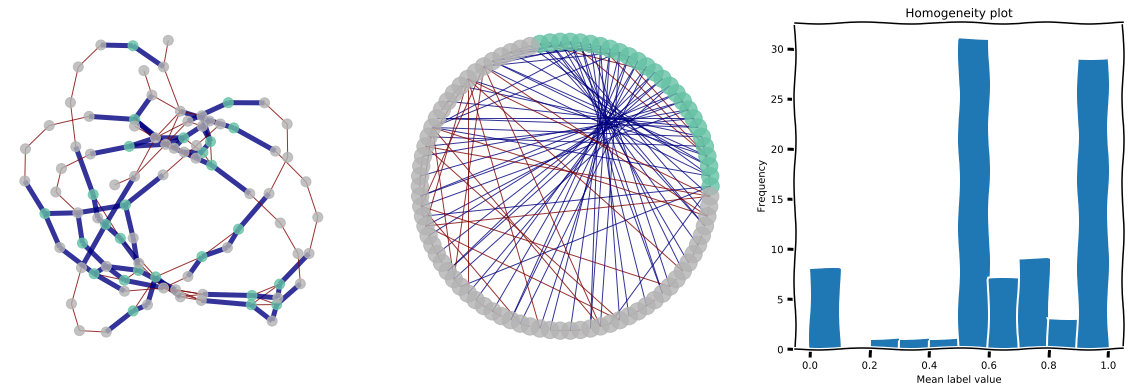

In [5]:
homogeneity_plot(G,labels)

**It will be bad practice to predict on this graph**
- 标签不一致的节点出现的蓝色的连接
- 标签一致的节点出现红色的连接
- 左图表明，绿色节点的连接常出现异构
- 中图也能够看出，绿色节点大量连接灰色节点
- 右图中，众数0.5，表明图不同质    


# 此图LPA肯定失败

### Semi-Supervised learning: Graph Nearest Neighbor Classifier

In [0]:
def relation_classifier(G, masked_labels,idx,labels):
    classified_labels = np.array(list(map(lambda n: np.round(np.nanmean(masked_labels[list(G.neighbors(n))])),idx)))
    accuracy = (labels[idx] == classified_labels).mean()
    return classified_labels, accuracy


def iterative_classifier(G, masked_labels,idx,labels,max_iters = 1000):

    # initial nodes masked
    init_idx = idx[:]

    # loop if there are unclassified labels
    iters = 0
    while np.isnan(masked_labels).sum()>0 or iters > max_iters:

        iters += 1

        # classification
        classified_labels = np.array(list(map(lambda n: np.round(np.nanmean(masked_labels[list(G.neighbors(n))])),idx)))

        # update labels
        masked_labels[idx] = classified_labels

        # update current unknow nodes
        idx = np.where(np.isnan(masked_labels))[0]

    accuracy = (masked_labels[init_idx] == labels[init_idx]).mean()
    return masked_labels, accuracy


def random_masking_accuracy(G,labels,mask_size = 40,trials = 1000,method = 'relational'):
    accs = []

    for _ in range(trials):
        masked_labels,idx = mask(labels,mask_size)

        if method == 'iterative':
            classified_labels, accuracy = iterative_classifier(G, masked_labels,idx,labels)
        elif method == 'relational':
            classified_labels, accuracy = relation_classifier(G, masked_labels,idx,labels)
        else:
            raise Exception('Bad Classification Method')
        accs.append(accuracy)

    plt.hist(accs)
    plt.title("Accuracy histogram",fontsize = 18)
    plt.xlabel("Accuracy")
    _ = plt.ylabel('Frequency')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


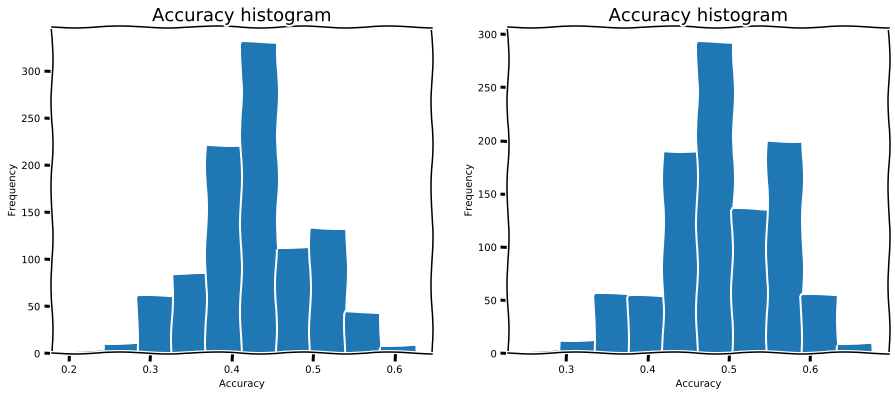

In [7]:
figsize(15,6)
plt.subplot(1,2,1)
random_masking_accuracy(G,labels,40,1000,method = 'relational')
plt.subplot(1,2,2)
random_masking_accuracy(G,labels,40,1000,method = 'iterative')

> **Worse than random guessing**

### Predict community of Karate Club Graph

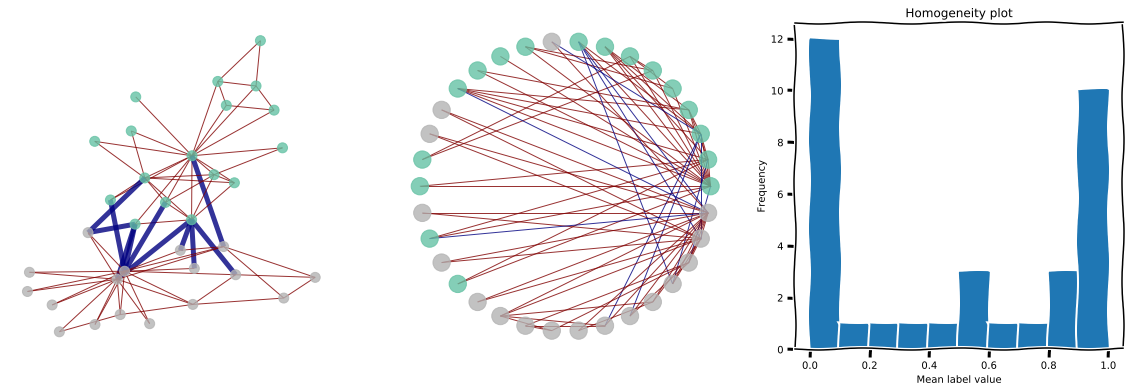

In [8]:
G = nx.karate_club_graph()
labels = [d['club'] for n,d in G.nodes(data = True)]
club_ids = {club:i for i, club in enumerate(set(labels))}
labels = np.array([club_ids[club] for club in labels],dtype = float)
homogeneity_plot(G,labels)

**Mask 15 node labels**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


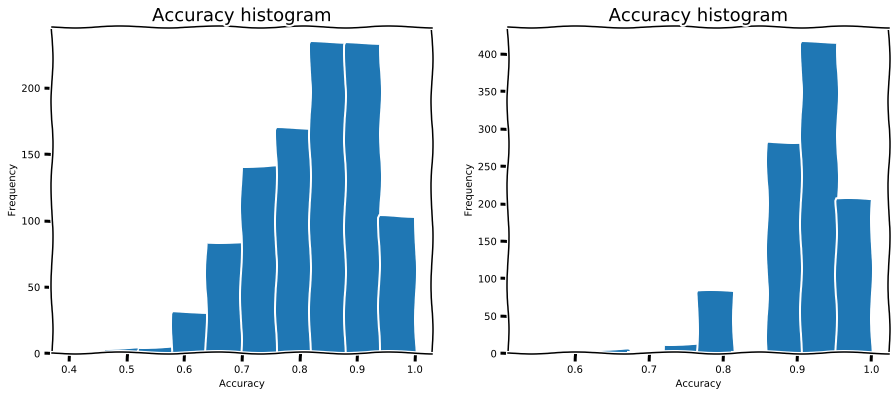

In [9]:
figsize(15,6)
plt.subplot(1,2,1)
random_masking_accuracy(G,labels,15,1000,method = 'relational')
plt.subplot(1,2,2)
random_masking_accuracy(G,labels,15,1000,method = 'iterative')

**Mask 20 node labels**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


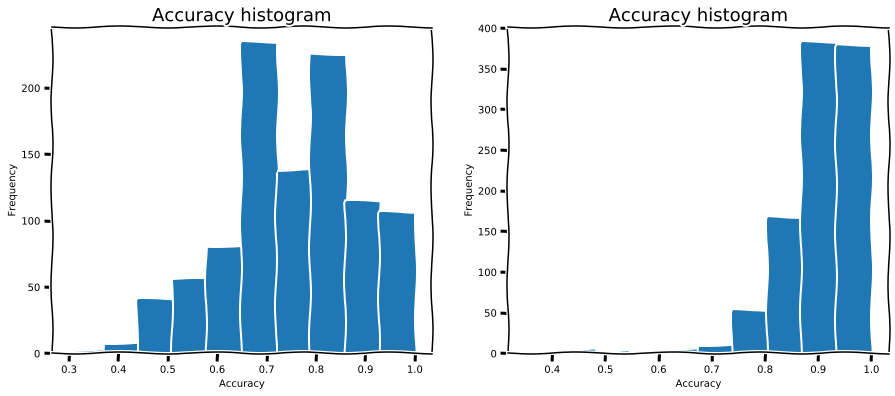

In [10]:
figsize(15,6)
plt.subplot(1,2,1)
random_masking_accuracy(G,labels,20,1000,method = 'relational')
plt.subplot(1,2,2)
random_masking_accuracy(G,labels,20,1000,method = 'iterative')

**Mask 25 node labels**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


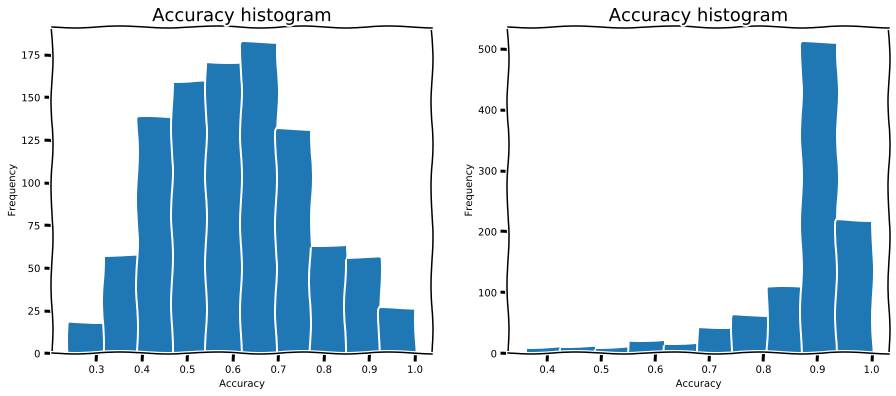

In [11]:
figsize(15,6)
plt.subplot(1,2,1)
random_masking_accuracy(G,labels,25,1000,method = 'relational')
plt.subplot(1,2,2)
random_masking_accuracy(G,labels,25,1000,method = 'iterative')

- Depending on which node is masked, the result can be different
- Initial labelled nodes can be a small portion of all grpah nodes -  for iterative classifier.

**Overview of classification reseult**

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


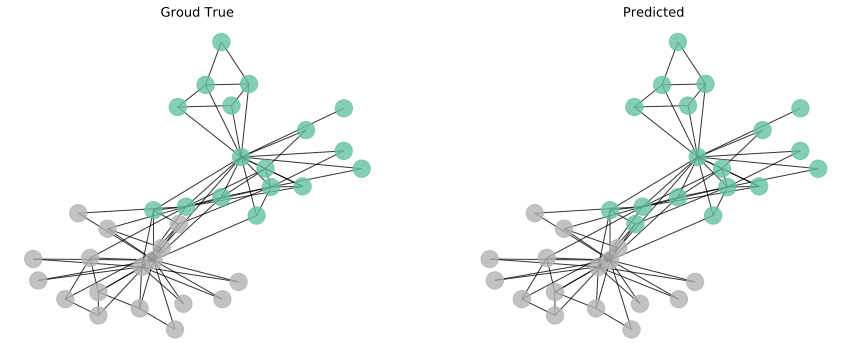

In [12]:
masked_labels,idx = mask(labels,15)
classified_labels, accuracy = relation_classifier(G,masked_labels,idx,labels)

groud_true = labels.copy()
groud_true[idx] = classified_labels

figsize(15,6)
pos = nx.spring_layout(G)
plt.subplot(1,2,1)
nx.draw(G,node_color = labels,pos = pos,alpha = .8,cmap = plt.get_cmap('Set2'))
plt.title("Groud True",fontsize = 13)
plt.subplot(1,2,2)
nx.draw(G,node_color = groud_true,pos = pos,alpha = .8,cmap = plt.get_cmap('Set2'))
plt.title("Predicted",fontsize = 13)
plt.show()

> **结论：LPA 作为一种社群划分的方法，相互连接的节点划分到一起，OK**         
> **若将LPA应用与预测，一定是有条件的，有条件的，有条件的**      
> **可以初始化一部分已知社群节点的，用于社群划分**

**<font color = 'darkred'>仅仅是把邻居的标签做平均，很多时候，能够得到非常不错的结果, 比如上面的 Karate Club Graph</font>**

In [0]:
# G = nx.karate_club_graph()
# labels = [d['club'] for n,d in G.nodes(data = True)]
# club_ids = {club:i for i, club in enumerate(set(labels))}
# labels = np.array([club_ids[club] for club in labels],dtype = float)
# homogeneity_plot(G,labels)
# masked_labels,idx = mask(labels,15)

## Random walk methods (Semi-supervised)
- Consider random walk with absorbing states - labeled nodes $V_{l}$
- Probability $\hat{y}_{i}[c]$ for node $v_{i} \in V_{u}$ to have label $c$ 

> $\hat{y}_{i}[c] = \sum\limits_{j \in V_{l}} p_{ij}^{\infty}y_{j}[c]$  
> where $y_{i}[c]$ - probability distribution over labels    
> $p_{ij} = P(i \to j)$ one step probability transition matrix element    

- If output requires single label per node, assign the most probable    
- In matrix form 

> $\hat{Y} = P^{\infty}Y$    
> $Y = (Y_{l},0), \hat{Y} = (Y_{l}, \hat{Y}_{u})$


**<font color = 'darkred'>Walk around until you hit the labeled nodes.</font>**

**<font color='darkred'>You can limit $t$ to constant steps</font>**

- Random walk matrix: $P = D^{-1}A$     
- Random walk with absorbing states: 
$P=
  \begin{pmatrix}
    P_{ll} & P_{lu}\\
    P_{ul} & P_{uu}
  \end{pmatrix} = 
    \begin{pmatrix}
    I & 0\\
    P_{ul} & P_{uu}
  \end{pmatrix}
$

- At time $t \to \infty$ limit:     


> $\lim\limits_{t \to \infty} P^{t}=
\begin{pmatrix}
    I & 0\\
    (\sum_{n=0}^{\infty} P^n_{uu})P_{ul} & P_{uu}^{\infty}
  \end{pmatrix} = 
  \begin{pmatrix}
    I & 0\\
    (1 - P_{uu})^{-1}P_{ul} & 0
  \end{pmatrix}
$    

> $
\begin{pmatrix}
    \hat{Y_{l}} \\
    \hat{Y_{u}} 
\end{pmatrix}=
\begin{pmatrix}
    I & 0\\
    (1 - P_{uu})^{-1}P_{ul} & 0
\end{pmatrix}
\begin{pmatrix}
    Y_{l} \\
    Y_{u}
\end{pmatrix}
$ 

**Solution:**
> $\hat{Y_{l}} = Y_{l}$    
> $\hat{Y_{u}} = (1 - P_{uu})^{-1}P_{ul}Y_{l}$

$(1 - P_{uu})^{-1}$ is non-singular for all label connected graphs   
**<font color = 'darkred'>(always possible to reach a labeled node from any unlabeled node)</font>**

OutEdgeView([(0, 0), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 4)])

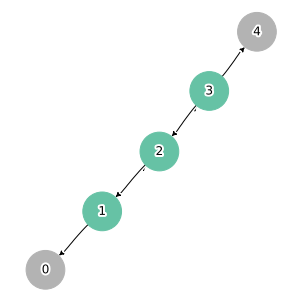

In [14]:
edges = [(0,0),(1,0),(1,2),(2,1),(2,3),(3,2),(3,4),(4,4)]
T = nx.from_edgelist(edges,create_using= nx.DiGraph)
figsize(4,4)
node_color= [1] + np.zeros(len(T.nodes) -2).tolist() + [1]
nx.draw(T,with_labels = True,node_color = node_color,
        cmap = plt.get_cmap("Set2"),node_size = 1500)
T.edges()

- Labeled nodes are trapped nodes.   
- Edge to node 0 and node 5 are directed edges (in edge), a walk to node 0 or 5 will stop there
- Add self loop to labeled nodes

### Grab your numpy and do matrix multiplication

In [15]:
A = np.array(nx.adj_matrix(T).todense())

# Note: D is out degree matrix
D = A.sum(axis = 1).reshape((-1,1))
D[np.where(D ==0)] = 1e-7
P = A / D
P = P[:,[0,-1,1,2,3,]]
P = P[[0,-1,1,2,3,],:]
P

array([[1. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0.5, 0. , 0.5],
       [0. , 0.5, 0. , 0.5, 0. ]])

In [16]:
Pt = P.copy()
for i in range(20):
    
    prev = Pt
    Pt = np.round(np.dot(Pt,P),2)

    if np.allclose(prev,Pt,atol=1e-7):
        print("Taking {} iterations to converge.".format(i))
        break

Taking 14 iterations to converge.


In [17]:
Pt

array([[1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.74, 0.24, 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.24, 0.74, 0.  , 0.  , 0.  ]])

**What really matters is**

In [18]:
Pt[2:,0:2]

array([[0.74, 0.24],
       [0.5 , 0.5 ],
       [0.24, 0.74]])

**Convergence is guaranteed, this is how you walk**

### Let's classify

In [0]:
# G = nx.karate_club_graph()
# labels = [d['club'] for n,d in G.nodes(data = True)]
# club_ids = {club:i for i, club in enumerate(set(labels))}
# labels = np.array([club_ids[club] for club in labels],dtype = float)

# n_nodes = len(G.nodes())

# # having 10 unlabeled nodes
# n_unlabeled = 25

# # number of labeled nodes
# n_labeled = len(G.nodes()) - n_unlabeled

# # masking
# masked_labels,idx = mask(labels, n_unlabeled)
# masked_nodes = np.where(np.isnan(masked_labels))[0]


# labeled_nodes = np.where(~np.isnan(masked_labels))[0]
# assert labeled_nodes.shape[0] + masked_nodes.shape[0] == len(G.nodes())


# node_order = np.r_[labeled_nodes,masked_nodes]
# new_old = {i:n for i,n in enumerate(node_order)}
# old_new = {v:k for k,v in new_old.items()}

# new_edges = []
# for u,v in G.edges():
#     new_edges.append((old_new[u],old_new[v]))

# G = nx.Graph()
# G.add_nodes_from(np.arange(n_nodes))
# G.add_edges_from(new_edges)
    
# new_labels = np.array([masked_labels[new_old[n]] for n in G.nodes()])

# A = nx.to_numpy_array(G)
# D = A.sum(axis = 1).reshape((-1,1))
# D[np.where(D ==0)] = 1e-7
# P = A / D
# P[0:n_labeled,n_labeled:] = 0

# puu = P[n_labeled:,n_labeled:]
# pul = P[n_labeled:,:n_labeled]
# eye = np.eye(puu.shape[0])

# yl = np.array(new_labels[:n_labeled]).reshape((-1,1))
# new_labels[n_labeled:] = (np.linalg.inv(eye-puu) @ pul @ yl).flatten()
# prob = {new_old[i]:new_labels[i] for i in G.nodes()}
# prob = [prob[n] for n in nx.karate_club_graph().nodes()]

# figsize(20,8)
# plt.subplot(1,2,1)
# G = nx.karate_club_graph()
# pos = nx.spring_layout(G)
# nx.draw(G,node_color = np.round(prob),cmap = plt.get_cmap('Set2'),with_labels = True,node_size = 1500,pos = pos)
# plt.title("Classification",fontsize = 15)
# plt.subplot(1,2,2)
# nx.draw(G,node_color = prob,cmap = plt.get_cmap('cool'),with_labels = True,node_size = 1500,pos = pos)
# plt.title("Probability",fontsize = 15)
# plt.show()

In [0]:
def random_walk_preprocessing(G,labels,n_unlabeled = 25):


    n_nodes = len(G.nodes())

    # number of labeled nodes
    n_labeled = len(G.nodes()) - n_unlabeled

    # masking
    masked_labels,idx = mask(labels, n_unlabeled)
    masked_nodes = np.where(np.isnan(masked_labels))[0]
    labeled_nodes = np.where(~np.isnan(masked_labels))[0]
    assert labeled_nodes.shape[0] + masked_nodes.shape[0] == len(G.nodes())

    # reordering nodes,labeled nodes prior to masked nodes
    node_order = np.r_[labeled_nodes,masked_nodes]

    # dictionaries to keep track of changes
    new_old = {i:n for i,n in enumerate(node_order)}
    old_new = {v:k for k,v in new_old.items()}

    # make a new graph
    new_edges = []
    for u,v in G.edges():
        new_edges.append((old_new[u],old_new[v]))

    G = nx.Graph()
    G.add_nodes_from(np.arange(n_nodes))
    G.add_edges_from(new_edges)

    # update labels  
    new_labels = np.array([masked_labels[new_old[n]] for n in G.nodes()])

    return G, new_labels, new_old, old_new, masked_nodes


def random_walk(G, n_labeled, labels,mapping):

    # adjacency, degree, transition
    A = nx.to_numpy_array(G)
    D = A.sum(axis = 1).reshape((-1,1))
    D[np.where(D ==0)] = 1e-7
    P = A / D
    P[0:n_labeled,n_labeled:] = 0

    # block matrices
    puu = P[n_labeled:,n_labeled:]
    pul = P[n_labeled:,:n_labeled]
    eye = np.eye(puu.shape[0])

    # labels
    yl = np.array(labels[:n_labeled]).reshape((-1,1))
    labels[n_labeled:] = (np.linalg.inv(eye-puu) @ pul @ yl).flatten()
    prob = {mapping[i]:labels[i] for i in G.nodes()}

    return prob

**Case1**

In [21]:
G = nx.karate_club_graph()
labels = [d['club'] for n,d in G.nodes(data = True)]
club_ids = {club:i for i, club in enumerate(set(labels))}
labels = np.array([club_ids[club] for club in labels],dtype = float)

# mask parameter
n_unlabeled = 25
n_labeled = len(G.nodes) - n_unlabeled

# preprocessing
new_G,new_labels,new_old,old_new,masked_nodes = random_walk_preprocessing(G,labels,n_unlabeled= n_unlabeled)

# model
prob = random_walk(new_G,n_labeled,new_labels,new_old)

# convert back to original graph probabilities
prob = [prob[n] for n in G.nodes()]

accuracy = (labels[masked_nodes] == np.round(prob)[masked_nodes]).mean()
print('Accuracy: {}%.'.format(round(accuracy * 100,2)))

print(classification_report(labels[masked_nodes],np.round(prob)[masked_nodes]))

Accuracy: 92.0%.
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93        15
         1.0       0.83      1.00      0.91        10

    accuracy                           0.92        25
   macro avg       0.92      0.93      0.92        25
weighted avg       0.93      0.92      0.92        25



findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


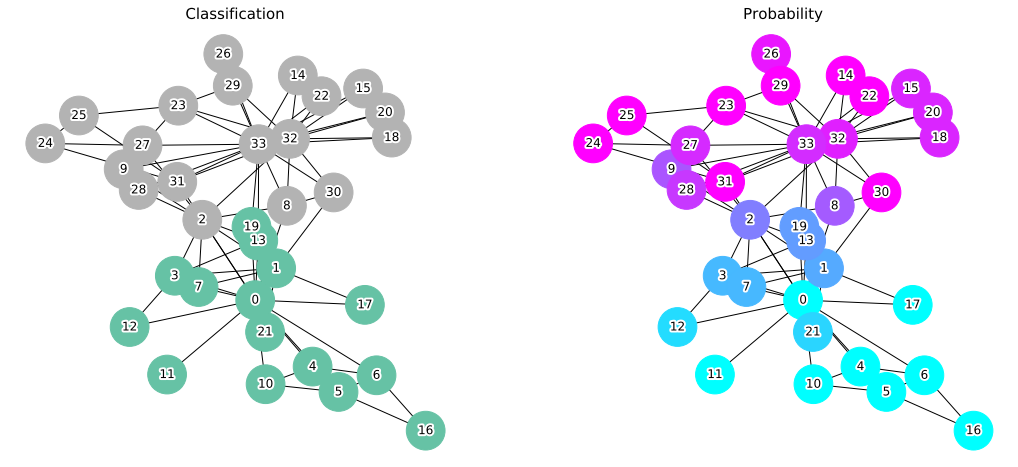

In [22]:
figsize(18,8)
plt.subplot(1,2,1)
pos = nx.spring_layout(G)
nx.draw(G,node_color = np.round(prob),cmap = plt.get_cmap('Set2'),with_labels = True,node_size = 1500,pos = pos)
plt.title("Classification",fontsize = 15)
plt.subplot(1,2,2)
nx.draw(G,node_color = prob,cmap = plt.get_cmap('cool'),with_labels = True,node_size = 1500,pos = pos)
plt.title("Probability",fontsize = 15)
plt.show()

**Case2**

In [25]:
G,labels = get_everything(root_path,edge_file,label_file)
# mask parameter
n_unlabeled = 20
n_labeled = len(G.nodes) - n_unlabeled

# preprocessing
new_G,new_labels,new_old,old_new,masked_nodes = random_walk_preprocessing(G,labels,n_unlabeled= n_unlabeled)

# model
prob = random_walk(new_G,n_labeled,new_labels,new_old)

# convert back to original graph probabilities
prob = [prob[n] for n in G.nodes()]

accuracy = (labels[masked_nodes] == np.round(prob)[masked_nodes]).mean()
print('Accuracy: {}%.'.format(round(accuracy * 100,2)))
print(classification_report(labels[masked_nodes],np.round(prob)[masked_nodes]))

Accuracy: 55.0%.
              precision    recall  f1-score   support

         0.0       0.27      0.75      0.40         4
         1.0       0.89      0.50      0.64        16

    accuracy                           0.55        20
   macro avg       0.58      0.62      0.52        20
weighted avg       0.77      0.55      0.59        20



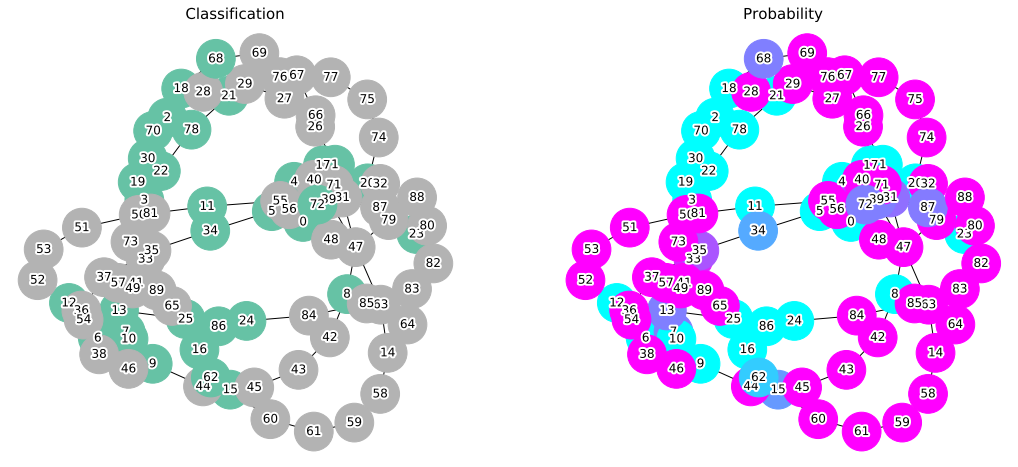

In [26]:
figsize(18,8)
plt.subplot(1,2,1)
pos = nx.spring_layout(G)
nx.draw(G,node_color = np.round(prob),cmap = plt.get_cmap('Set2'),with_labels = True,node_size = 1500,pos = pos)
plt.title("Classification",fontsize = 15)
plt.subplot(1,2,2)
nx.draw(G,node_color = prob,cmap = plt.get_cmap('cool'),with_labels = True,node_size = 1500,pos = pos)
plt.title("Probability",fontsize = 15)
plt.show()

*Again, a bad score*

### Iterative randomwalk
- Matrix inverse take a lot of resources in large graph calculate
- Alternatively, we use iterations to get the result
- When Error is acceptable, stop iteration

In [0]:
def iterative_random_walk(G, n_labeled, labels, new_old = new_old,max_iters = 2000,tol = 1e-7):

    # adjacency, degree, transition
    A = nx.to_numpy_array(G)
    D = A.sum(axis = 1).reshape((-1,1))
    D[np.where(D ==0)] = 1e-7
    P = A / D
    P[0:n_labeled,n_labeled:] = 0

    # labels
    y = labels.copy()
    y[n_labeled:] = 0

    for iter in range(max_iters):
        prev_y = y.copy()
        y = np.dot(P,y)
        y[:n_labeled] = labels[:n_labeled]
        if np.allclose(y, prev_y,atol = tol):
            break

    y = y.flatten()
    y = {new_old[i]:y[i] for i in G.nodes()}

    print('Taking {} iterations.'.format(iter))
    return y

In [30]:
G = nx.karate_club_graph()
labels = [d['club'] for n,d in G.nodes(data = True)]
club_ids = {club:i for i, club in enumerate(set(labels))}
labels = np.array([club_ids[club] for club in labels],dtype = float)

# mask parameter
n_unlabeled = 25
n_labeled = len(G.nodes) - n_unlabeled

# preprocessing
new_G,new_labels,new_old,old_new,masked_nodes = random_walk_preprocessing(G,labels,n_unlabeled= n_unlabeled)

# model
prob = iterative_random_walk(new_G,n_labeled,new_labels,new_old)

# convert back to original graph probabilities
prob = [prob[n] for n in G.nodes()]

accuracy = (labels[masked_nodes] == np.round(prob)[masked_nodes]).mean()
print('Accuracy: {}%.'.format(round(accuracy * 100,2)))

print(classification_report(labels[masked_nodes],np.round(prob)[masked_nodes]))

Taking 55 iterations.
Accuracy: 96.0%.
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        13
         1.0       1.00      0.92      0.96        12

    accuracy                           0.96        25
   macro avg       0.96      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25



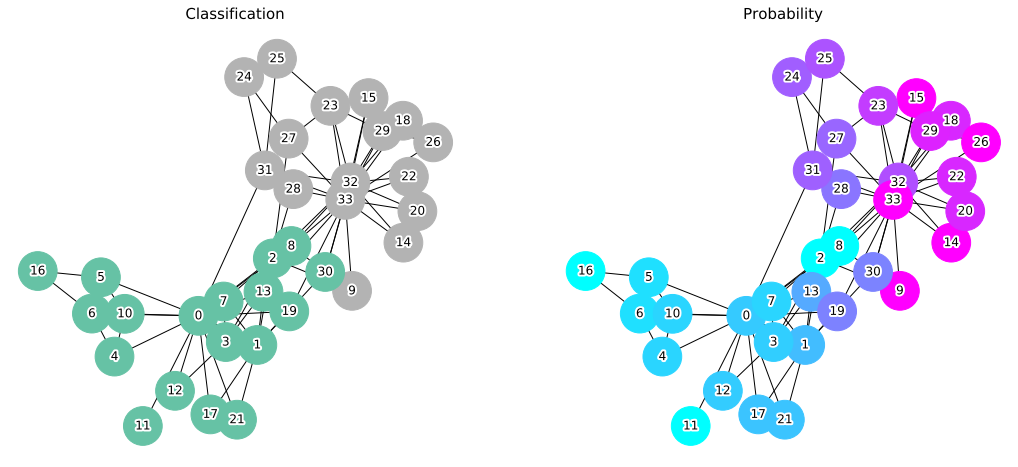

In [31]:
figsize(18,8)
plt.subplot(1,2,1)
pos = nx.spring_layout(G)
nx.draw(G,node_color = np.round(prob),cmap = plt.get_cmap('Set2'),with_labels = True,node_size = 1500,pos = pos)
plt.title("Classification",fontsize = 15)
plt.subplot(1,2,2)
nx.draw(G,node_color = prob,cmap = plt.get_cmap('cool'),with_labels = True,node_size = 1500,pos = pos)
plt.title("Probability",fontsize = 15)
plt.show()

## Label Spreading

**Power Iteration**      
$\hat{Y}^{(t+1)} = \alpha S \hat Y ^{(t)} + (1 - \alpha) Y^{(0)}$     
$S = D^{-1/2}AD^{-1/2}$     
$Y^{(0)} = (Y_{l},0)$

**Numerical solution**

$\hat{Y} = (1 - \alpha) (1 - \alpha S)^{-1} Y^{(0)}$



In [0]:
def label_spreading(G, n_labeled, labels, new_old = new_old, alpha = 0.85, max_iters = 2000,tol = 1e-7):

    # adjacency, degree, transition
    A = nx.to_numpy_array(G)
    D = A.sum(axis = 1)
    D[np.where(D ==0)] = 1e-7
    D = 1/ np.sqrt(D)
    D = np.diag(D.flatten())
    S = np.dot(np.dot(D,A),D)

    # labels
    y = labels.copy()
    y[n_labeled:] = 0

    y = np.dot((1- alpha) * np.linalg.inv(1 - alpha * S),y)


    y = y.flatten()
    y = {new_old[i]:y[i] for i in G.nodes()}

    return y

In [33]:
G = nx.karate_club_graph()
labels = [d['club'] for n,d in G.nodes(data = True)]
club_ids = {club:i for i, club in enumerate(set(labels))}
labels = np.array([club_ids[club] for club in labels],dtype = float)

# mask parameter
n_unlabeled = 25
n_labeled = len(G.nodes) - n_unlabeled

# preprocessing
new_G,new_labels,new_old,old_new,masked_nodes = random_walk_preprocessing(G,labels,n_unlabeled= n_unlabeled)

# model
prob = label_spreading(new_G, n_labeled, new_labels, new_old = new_old, alpha = 0.8, max_iters = 2000,tol = 1e-7)

# convert back to original graph probabilities
prob = [prob[n] for n in G.nodes()]

accuracy = (labels[masked_nodes] == np.round(prob)[masked_nodes]).mean()
print('Accuracy: {}%.'.format(round(accuracy * 100,2)))

print(classification_report(labels[masked_nodes],np.round(prob)[masked_nodes]))

LinAlgError: ignored

In [0]:
def label_spreading_iteration(G, n_labeled, labels, new_old = new_old, alpha = 0.85, max_iters = 2000,tol = 1e-7):

    # adjacency, degree, transition
    A = nx.to_numpy_array(G)
    D = np.sqrt(np.diag(1.0/sum(A)))
    S = np.dot(np.dot(D,A),D)

    # labels
    y = labels.copy()
    y[n_labeled:] = 0
    y = y.reshape((-1,1))
    y_init = y.copy()

    for iter in range(max_iters):
        prev_y = y.copy()

        y = alpha * np.dot(S,y) + (1 - alpha) * y_init
        if np.allclose(prev_y, y, atol = tol):
            print('Taking {} iterations.'.format(iter))
            break

    y = y.flatten()
    y = {new_old[i]:y[i] for i in G.nodes()}
    return y

In [44]:
G = nx.karate_club_graph()
labels = [d['club'] for n,d in G.nodes(data = True)]
club_ids = {club:i for i, club in enumerate(set(labels))}
labels = np.array([club_ids[club] for club in labels],dtype = float)

# mask parameter
n_unlabeled = 28
n_labeled = len(G.nodes) - n_unlabeled

# preprocessing
new_G,new_labels,new_old,old_new,masked_nodes = random_walk_preprocessing(G,labels,n_unlabeled= n_unlabeled)

# model
prob = label_spreading_iteration(new_G, n_labeled, new_labels, new_old = new_old, alpha = 0.7, max_iters = 2000,tol = 1e-7)

# convert back to original graph probabilities
prob = [prob[n] for n in G.nodes()]

accuracy = (labels[masked_nodes] == np.round(prob)[masked_nodes]).mean()
print('Accuracy: {}%.'.format(round(accuracy * 100,2)))

print(classification_report(labels[masked_nodes],np.round(prob)[masked_nodes]))

Taking 23 iterations.
Accuracy: 46.43%.
              precision    recall  f1-score   support

         0.0       0.46      1.00      0.63        13
         1.0       0.00      0.00      0.00        15

    accuracy                           0.46        28
   macro avg       0.23      0.50      0.32        28
weighted avg       0.22      0.46      0.29        28



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


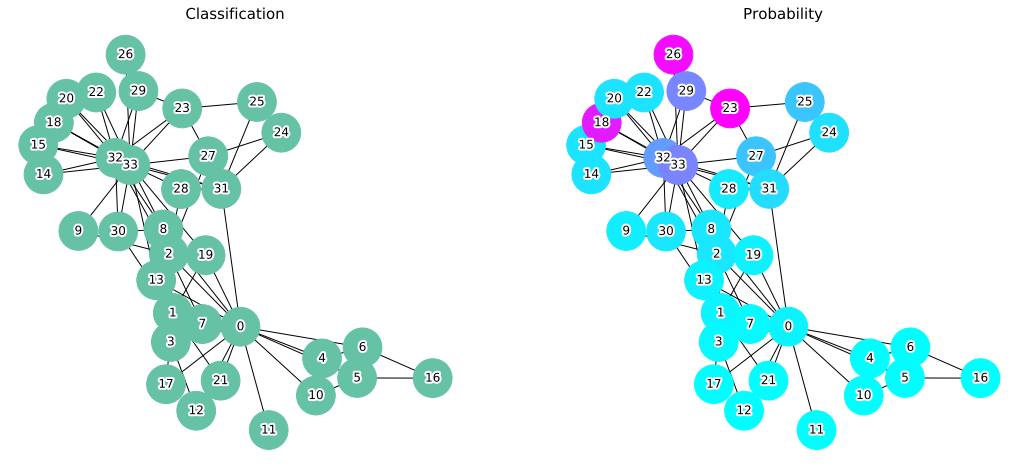

In [37]:
figsize(18,8)
plt.subplot(1,2,1)
pos = nx.spring_layout(G)
nx.draw(G,node_color = np.round(prob),cmap = plt.get_cmap('Set2'),with_labels = True,node_size = 1500,pos = pos)
plt.title("Classification",fontsize = 15)
plt.subplot(1,2,2)
nx.draw(G,node_color = prob,cmap = plt.get_cmap('cool'),with_labels = True,node_size = 1500,pos = pos)
plt.title("Probability",fontsize = 15)
plt.show()

PROTEINS-full contains the following comma separated text files:

n: total number of nodes
m: total number of edges
N: number of graphs


**.node_attrs (n lines)**    
	- matrix of node attributes,    
	- the comma seperated values in the i-th line is the attribute vector of the node with node_id i

**.node_labels (n lines)**    
	- column vector of node labels,    
	- the value in the i-th line corresponds to the node with node_id i

**.edges (m lines)**    
	- sparse (block diagonal) adjacency matrix for all graphs,    
	- each line corresponds to (row, col) resp. (node_id, node_id)

**.graph_labels (N lines)**       
	- class labels for all graphs in the dataset,    
	- the value in the i-th line is the class label of the graph with graph_id i

**.graph_idx (n lines)**    
	- column vector of graph identifiers for all nodes of all graphs,    
	- the value in the i-th line is the graph_id of the node with node_id i


In [0]:
root_path = '/content/drive/My Drive/Network Codes/datasets'
protein_edge_path = os.path.join(root_path,'PROTEINS-full.edges')
protein_graph_path = os.path.join(root_path,'PROTEINS-full.graph_idx')
protein_graph_labels_path = os.path.join(root_path,'PROTEINS-full.graph_labels')
protein_attr_path = os.path.join(root_path,'PROTEINS-full.node_attrs')
protein_node_labels_path = os.path.join(root_path,'PROTEINS-full.node_labels')

def read_protein():
    with open(protein_graph_path,'r') as f:
        node_g_id = []
        for line in f:
            node_g_id.append(int(line.strip()))

    with open(protein_graph_labels_path,'r') as f:
        g_labels = []
        for line in f:
            g_labels.append(int(line.strip()))

    node_feature_df = pd.read_csv(protein_attr_path,header=None)
    node_feature_df.columns = ['f_'+str(f) for f in node_feature_df.columns]

    with open(protein_node_labels_path,'r') as f:
        node_labels = []
        for line in f:
            node_labels.append(int(line.strip()))

    with open(protein_edge_path,'r') as f:
        edge_list = []
        for line in f:
            edge = line.strip().split(',')
            edge_list.append([int(edge[0]),int(edge[1])])

    protein_dict = {'node_g_id':node_g_id, 'g_labels':g_labels, 'node_feature_df':node_feature_df, 'node_labels':node_labels, 'edge_list':edge_list}

    for k, v in protein_dict.items():
        print('Number of {} : {}.'.format(k,len(v)))

    return protein_dict,node_g_id

In [49]:
protein,node_g_id = read_protein()
graph_selector_df = pd.DataFrame(Counter(node_g_id).most_common(),columns = ['Graph_id','Number_nodes'])
graph_selector_df.head(30)

Number of node_g_id : 43471.
Number of g_labels : 1113.
Number of node_feature_df : 43471.
Number of node_labels : 43471.
Number of edge_list : 162088.


,Graph_id,Number_nodes
0,77,620
1,245,504
2,21,481
3,6,336
4,309,328
5,18,285
6,233,273
7,282,246
8,107,244
9,180,229


In [0]:
def get_sub_graph(protein, idx,graph_selector_df = graph_selector_df):

    graph_nodes = np.where(np.array(protein['node_g_id']) == idx )[0]
    n_graph_nodes = len(graph_nodes)
    assert n_graph_nodes == graph_selector_df.loc[graph_selector_df.Graph_id == idx,'Number_nodes'].values[0]

    sub_edges = []
    for u,v in protein['edge_list']:
        if u in graph_nodes and v in graph_nodes:
            sub_edges.append([u,v])

    G = nx.from_edgelist(sub_edges)
    labels = dict(zip(graph_nodes,np.array(protein['node_labels'])[graph_nodes]))
    labels = np.array([labels[n] for n in G.nodes()],dtype = float)
    G = nx.convert_node_labels_to_integers(G)
    homogeneity_plot(G,labels)

    return G, labels

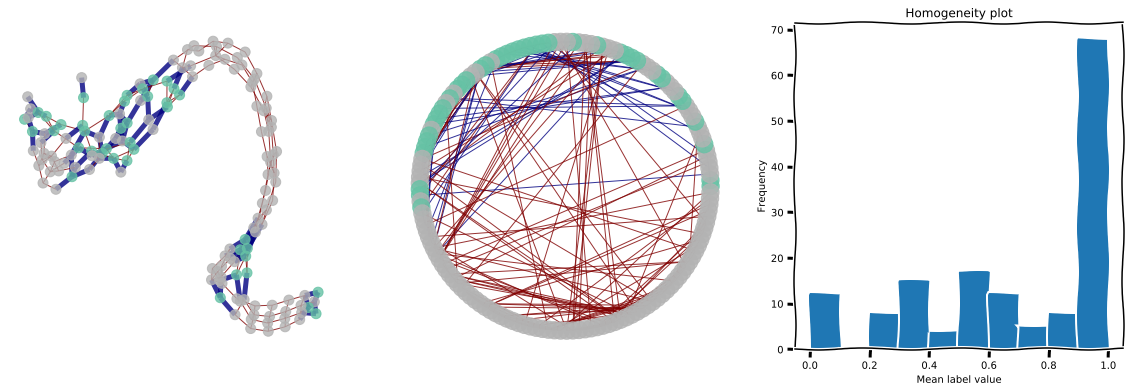

In [51]:
G,labels = get_sub_graph(protein, 761 ,graph_selector_df)

In [53]:
# mask parameter
n_unlabeled = 130
n_labeled = len(G.nodes) - n_unlabeled

# preprocessing
new_G,new_labels,new_old,old_new,masked_nodes = random_walk_preprocessing(G,labels,n_unlabeled= n_unlabeled)

# model
prob = iterative_random_walk(new_G,n_labeled,new_labels,new_old)

# convert back to original graph probabilities
prob = [prob[n] for n in G.nodes()]

accuracy = (labels[masked_nodes] == np.round(prob)[masked_nodes]).mean()
print('Accuracy: {}%.'.format(round(accuracy * 100,2)))

print(classification_report(labels[masked_nodes],np.round(prob)[masked_nodes]))

Taking 314 iterations.
Accuracy: 73.08%.
              precision    recall  f1-score   support

         0.0       0.50      0.54      0.52        35
         1.0       0.83      0.80      0.81        95

    accuracy                           0.73       130
   macro avg       0.66      0.67      0.67       130
weighted avg       0.74      0.73      0.73       130

